In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Assumption and objective:
1. In early stage, no social and government's intervention to the virus spread
2. Temperature and population density are the only two factors deternmining the spread
3. Early stage is defined by the time when the number of infected case is a certain percentage of the up-to-data number. 
4. Intected case percent is used to deternmine the early state so that the effect of population density is removed
5. The spread rate in early stage is only affected by temperature which is related to latitude.
6. We want to know whether temperature is a key factor determining the virus spread

In [ ]:
data=pd.read_csv('/kaggle/input/covid19-global-forecasting-week-1/train.csv',  header = 0, parse_dates = True)
data = data.dropna(subset=['Lat'],axis='rows')
lat=data['Lat'].unique()  
#load data and put all latitude value to a list

In [ ]:
from pprint import pprint 
Max_by_lat={}  #dic of latitude and the total number of cofirmed case
Start_date_by_lat = {}   #dic of latitude and the data when the fist case appeared
for la in lat:
    Max_by_lat[la]=(data.groupby(['Lat']).get_group(la)['ConfirmedCases'].max(),\
                          data.groupby(['Lat']).get_group(la)['Fatalities'].max(),\
                            data.groupby(['Lat']).get_group(la)['Country/Region'].unique()[0] if data.groupby(['Lat']).get_group(la)['Province/State'].isnull().unique()[0] == True else data.groupby(['Lat']).get_group(la)['Province/State'].unique()[0])
    Start_date_by_lat[la] = data.groupby(['Lat']).get_group(la).query('ConfirmedCases != 0.0').head(1)['Date']
pprint(Max_by_lat)
pprint(Start_date_by_lat)

In [ ]:
def early_stage_rate(stop_percent):    #stop_percent is the percent we use to determine the end of early stage
    data["min_gap"] = 0
    for k, v in Max_by_lat.items():
        stop_cases = stop_percent * v[0]
        mask=[la==k for la in data['Lat']]
        data["min_gap"][mask] = abs(data[mask]['ConfirmedCases']-stop_cases)
    
    end_date_by_lat={}
    for k, v in Max_by_lat.items():
        i=data.groupby('Lat').get_group(k)['min_gap'].idxmin() 
        end_date_by_lat[k]= (data['Date'][i], data['ConfirmedCases'][i]) #find the date of early stage end and put it in a dic
    
    average_rate = {}
    for k, v in end_date_by_lat.items():
        try:
            start_date = Start_date_by_lat[k].values[0]
            end_date = v[0]
            lat = k
            start_cases = 0
            end_cases = v[1]
            if start_date==end_date:
                average_rate[k]=0
            else:
                average_rate[k] = calculate_rate(start_date, start_cases, end_date, end_cases)
        except:
            continue
    return average_rate     #average rate=# of cases in early stage/# of days in early stage

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
rate=early_stage_rate(0.15)
plt.scatter([abs(la) for la in rate.keys()],[rate for rate in rate.values()])
plt.ylim([-5, 200])   # when we set the threshold of early stage is 5%, let's see the rate with temperature. Lower latitude, higher temperature

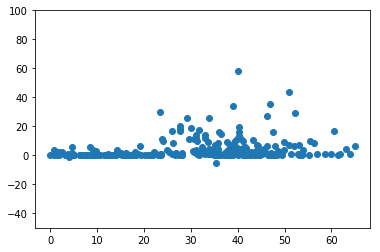
When early stage threshold=0.1

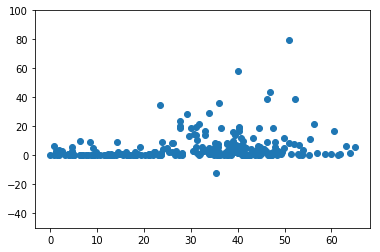
When early stage threshold=0.15

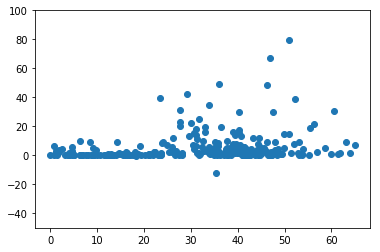
When early stage threshold=0.2

Conclusion:

When lattitude is lower than 30, the spread rate is alway low. The higest range of the spread rate is locaed between 40-50. So, the virus can fast spread at comparatively lower temperature if no external intervention.